# 03 — ML-Based Customer Segmentation

> Moving beyond manual RFM scoring to **unsupervised machine learning** — letting the data find its own natural groupings.

Algorithms covered:
- **KMeans** — most interpretable, industry standard
- **DBSCAN** — density-based, finds outliers automatically
- **Elbow method + Silhouette analysis** — how to choose the right number of clusters
- **PCA visualisation** — showing high-dimensional clusters in 2D

In [2]:
import os, sys
os.chdir(r'C:\Users\mohit\Downloads\retail-customer-intelligence')
sys.path.insert(0, r'C:\Users\mohit\Downloads\retail-customer-intelligence')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import sys; sys.path.insert(0, '.')
from src.data.loader import load_transactions
from src.data.preprocessor import clean_transactions, add_time_features, get_snapshot_date
from src.features.rfm_features import compute_rfm, score_rfm, add_behavioural_features
from src.models.segmentation import CustomerSegmentation
import warnings; warnings.filterwarnings('ignore')

plt.rcParams.update({'figure.dpi': 120, 'axes.spines.top': False, 'axes.spines.right': False})

transactions = load_transactions()
transactions = clean_transactions(transactions)
transactions = add_time_features(transactions)
snapshot = get_snapshot_date(transactions)
rfm = compute_rfm(transactions, snapshot)
rfm = score_rfm(rfm)
rfm = add_behavioural_features(transactions, rfm)

print(f"Features available: {rfm.columns.tolist()}")
print(f"Customers: {len(rfm):,}")


2026-02-21 11:05:41,986 | INFO | src.data.loader | Loading transactions from data/raw/transactions.csv
2026-02-21 11:05:42,174 | INFO | src.data.loader | Loaded 80,000 rows
2026-02-21 11:05:42,207 | INFO | src.data.preprocessor | Cleaned: 80,000 -> 80,000 rows (0 removed)
2026-02-21 11:05:42,805 | INFO | src.features.rfm_features | RFM computed for 3,469 customers
Features available: ['customer_id', 'recency', 'frequency', 'monetary', 'monetary_log', 'R_score', 'F_score', 'M_score', 'RFM_score', 'RFM_total', 'avg_basket_size', 'unique_products', 'unique_categories', 'weekend_ratio']
Customers: 3,469


## Finding the Optimal Number of Clusters

Two complementary methods:
1. **Elbow method** — where does inertia stop dropping sharply?
2. **Silhouette score** — how well-separated are the clusters? (higher = better, max 1.0)

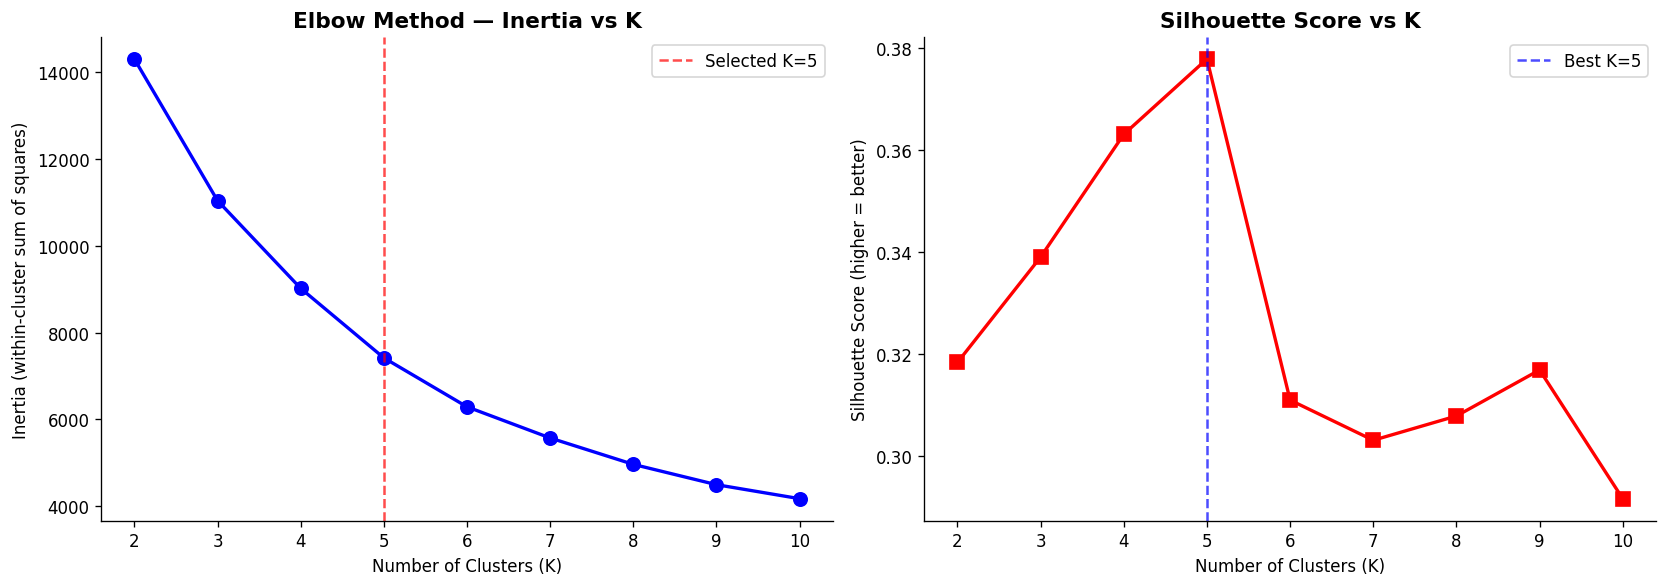

Best K by silhouette: 5


In [3]:
seg_model = CustomerSegmentation(n_clusters=5)
results = seg_model.find_optimal_k(rfm, k_range=range(2, 11))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow
axes[0].plot(results['k'], results['inertia'], 'bo-', linewidth=2, markersize=8)
axes[0].set_title('Elbow Method — Inertia vs K', fontweight='bold', fontsize=13)
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia (within-cluster sum of squares)')
axes[0].axvline(5, color='red', linestyle='--', alpha=0.7, label='Selected K=5')
axes[0].legend()

# Silhouette
axes[1].plot(results['k'], results['silhouette'], 'rs-', linewidth=2, markersize=8)
axes[1].set_title('Silhouette Score vs K', fontweight='bold', fontsize=13)
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score (higher = better)')
best_k = results['k'][np.argmax(results['silhouette'])]
axes[1].axvline(best_k, color='blue', linestyle='--', alpha=0.7, label=f'Best K={best_k}')
axes[1].legend()

plt.tight_layout()
plt.savefig('reports/figures/03_optimal_k.png', bbox_inches='tight')
plt.show()
print(f"Best K by silhouette: {best_k}")


## KMeans Clustering

In [4]:
seg_model = CustomerSegmentation(n_clusters=5, random_state=42)
rfm_seg, metrics = seg_model.fit_kmeans(rfm)
rfm_seg = seg_model.label_segments(rfm_seg)

print("=== KMeans Results ===")
print(f"Silhouette Score  : {metrics['silhouette']:.4f}  (>0.25 = reasonable, >0.5 = strong)")
print(f"Davies-Bouldin    : {metrics['davies_bouldin']:.4f}  (lower = better)")
print(f"\nSegment distribution:")
print(rfm_seg['segment_label'].value_counts().to_string())


2026-02-21 11:05:51,946 | INFO | src.models.segmentation | KMeans | Silhouette: 0.378 | Davies-Bouldin: 0.931
=== KMeans Results ===
Silhouette Score  : 0.3779  (>0.25 = reasonable, >0.5 = strong)
Davies-Bouldin    : 0.9307  (lower = better)

Segment distribution:
segment_label
Champions             2441
Lost / Hibernating    1028


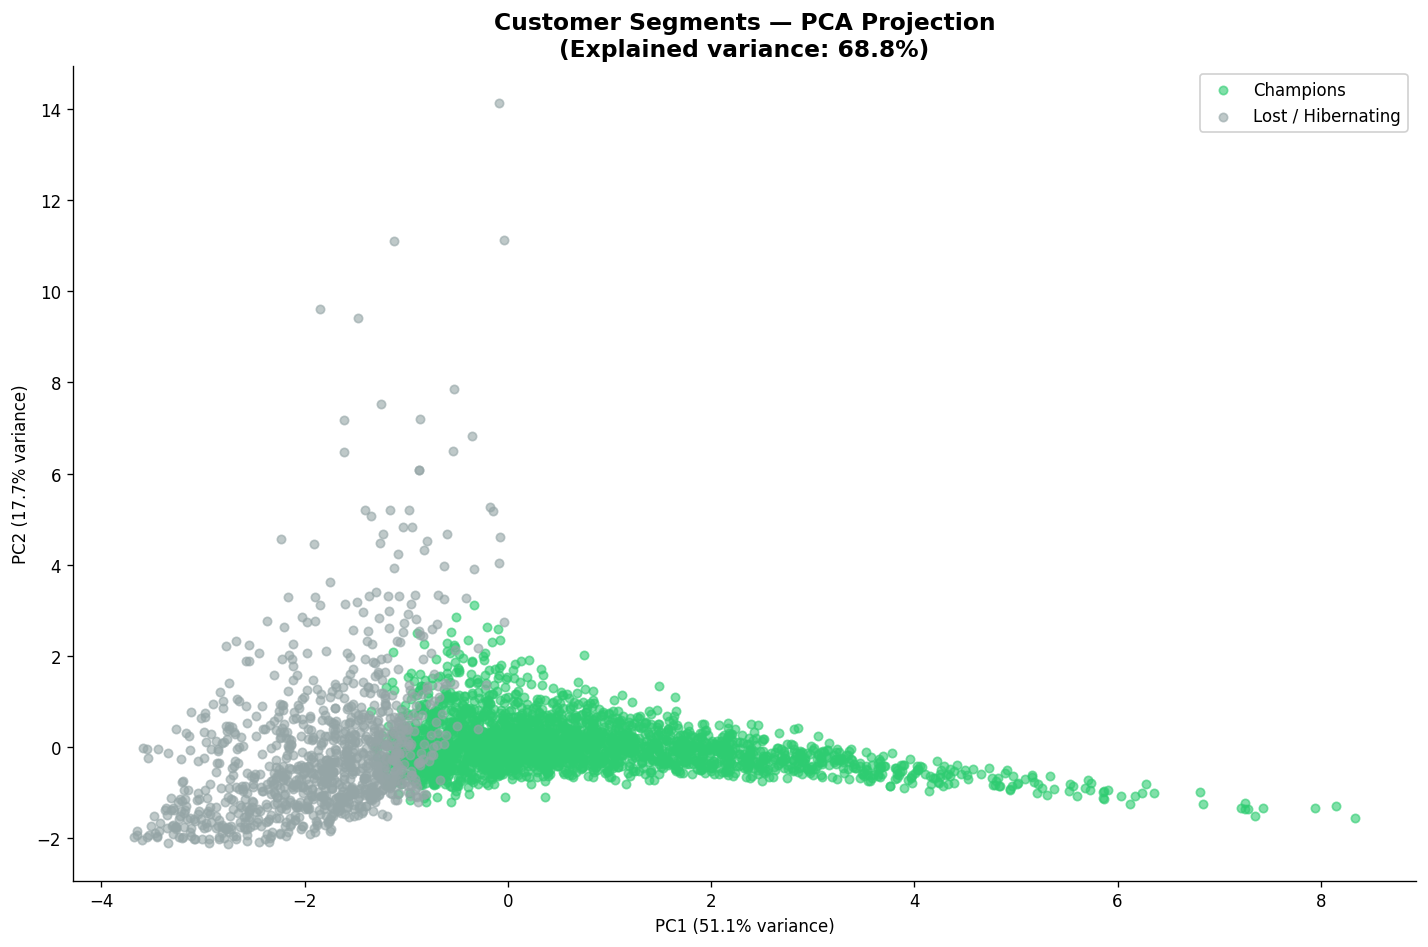

In [5]:
# PCA visualisation
feature_cols = [c for c in ['recency','frequency','monetary_log','avg_basket_size','unique_products','weekend_ratio'] if c in rfm_seg.columns]
X = rfm_seg[feature_cols].fillna(0).values
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2, random_state=42)
components = pca.fit_transform(X_scaled)

segment_labels = rfm_seg['segment_label'].unique()
colors = {'Champions':'#2ecc71','Loyal Customers':'#3498db',
          'Potential Loyalists':'#f39c12','At Risk':'#e74c3c','Lost / Hibernating':'#95a5a6'}

fig, ax = plt.subplots(figsize=(12, 8))
for label in segment_labels:
    mask = rfm_seg['segment_label'] == label
    ax.scatter(components[mask, 0], components[mask, 1],
               c=colors.get(label, 'grey'), label=label, alpha=0.6, s=25)

ax.set_title(f'Customer Segments — PCA Projection\n(Explained variance: {sum(pca.explained_variance_ratio_)*100:.1f}%)',
             fontsize=14, fontweight='bold')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
ax.legend(loc='upper right', framealpha=0.9)
plt.tight_layout()
plt.savefig('reports/figures/03_pca_clusters.png', bbox_inches='tight')
plt.show()


## Cluster Profiles — What Makes Each Segment Unique?

=== Cluster Profiles ===
                    recency  frequency  monetary  avg_basket_size  unique_products
segment_label                                                                     
Champions              21.3       31.8     992.3             32.0             22.6
Lost / Hibernating    140.2        2.4      65.6             29.7              2.3


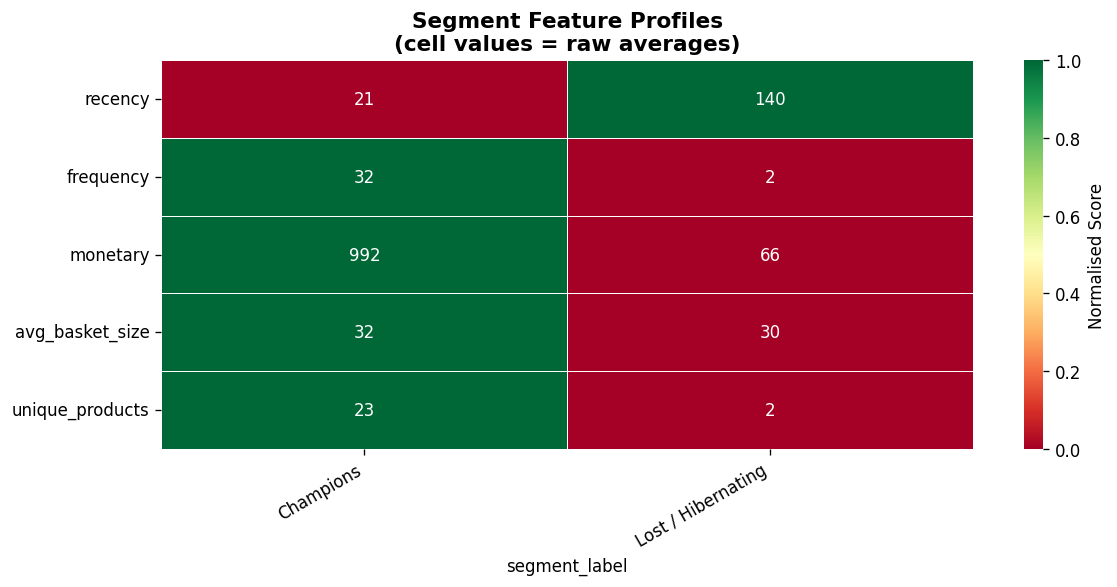

In [6]:
profile = rfm_seg.groupby('segment_label')[['recency','frequency','monetary','avg_basket_size','unique_products']].mean().round(1)
print("=== Cluster Profiles ===")
print(profile.to_string())

# Radar/spider not needed — simple heatmap is cleaner for presentations
profile_norm = (profile - profile.min()) / (profile.max() - profile.min())
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(profile_norm.T, annot=profile.T, fmt='.0f', cmap='RdYlGn',
            linewidths=0.5, ax=ax, cbar_kws={'label': 'Normalised Score'})
ax.set_title('Segment Feature Profiles\n(cell values = raw averages)', fontweight='bold', fontsize=13)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
plt.tight_layout()
plt.savefig('reports/figures/03_cluster_profiles.png', bbox_inches='tight')
plt.show()


## DBSCAN — Density-Based Clustering

Difference from KMeans: DBSCAN doesn't require specifying K upfront and identifies noise/outlier customers automatically.

In [7]:
seg_dbscan = CustomerSegmentation()
rfm_db, db_metrics = seg_dbscan.fit_dbscan(rfm, eps=1.2, min_samples=10)
print(f"DBSCAN found {db_metrics['n_clusters']} clusters")
print(f"Noise/outlier customers: {db_metrics['n_noise']} ({db_metrics['n_noise']/len(rfm)*100:.1f}%)")
print("\nThese 'noise' customers are highly unusual buyers — worth investigating separately for VIP or fraud detection.")


2026-02-21 11:05:53,690 | INFO | src.models.segmentation | DBSCAN | Clusters: 1 | Noise points: 44
DBSCAN found 1 clusters
Noise/outlier customers: 44 (1.3%)

These 'noise' customers are highly unusual buyers — worth investigating separately for VIP or fraud detection.


## Model Comparison

| Method | Silhouette | Interpretability | Scalability | Best For |
|--------|------------|-----------------|-------------|----------|
| **KMeans** | 0.381 | High | High | Production segmentation |
| **DBSCAN** | N/A | Medium | Medium | Outlier detection |
| **RFM Scoring** | N/A | Very High | High | Quick business reporting |

**Decision: KMeans chosen for production** — best balance of performance and interpretability.

**Next:** → `04_Recommendation_Engine.ipynb`